The following provides some motivation for developing a realistic noise-model simulation of the single-qubit readout process, i.e. simulated IQ trajectories. This would allow us to $\textbf{(1)}$ advance the transition-error-flagging study, and $\textbf{(2)}$ begin to construct realistic multi-qubit readout data (which Giuseppe mentioned could be useful for testbenching multi-qubit functionality in QICK).

QuTiP simulation code courtesy of Qihao Guo (Purdue).

# 1. Background



The QICK-optimized NN has been benchmarked against time-average thresholding ($\texttt{Neural network vs. thresholding, K-fold cross-validation.ipynb}$) and a suite of simple ML algorithms that would also be easy to implement on hardware ($\texttt{Qubit Readout Suite.ipynb}$). 

This NN's robustness to time-shifted inputs has also been benchmarked against thresholding ($\texttt{time\_shift\_robustness.ipynb}$), as well as a time-shift-invariant NN (trained in $\texttt{workflow\_shifted.ipynb}$, data generated in $\texttt{make\_time\_shifted\_data.ipynb}$). 

This was all possible because of an abundance of real qubit data, courtesy of Ma Lab. 

We tried to train a NN to spot and flag readout-induced transition errors as early as possible ($\texttt{classify\_errors.ipynb}$, $\texttt{classify\_errors\_double.ipynb}$). While the plots below show some better-than-chance predictability, ultimately the model achieves very low precision. 

This persists regardless of the rebalancing schema used for training or validation. Moreover, the NN does not converge at all if it is below a certain size (in terms of number of parameters). This hints that transition-error detection is complex enough to require a larger variance of transition-error samples in the dataset.

In [1]:
import os
from IPython.display import Image
import numpy as np

LOAD_DIR = "/data/aelabd/ml-quantum-readout/notebooks/transition_errors/66"

creport_path = os.path.join(LOAD_DIR, "classification_report_validation_set.npy")
creport = np.load(creport_path)
print("Classification report:")
print(creport)

Classification report:
                  precision    recall  f1-score   support

               0       0.96      0.77      0.85    134229
               1       0.98      0.75      0.85    126553
Relaxation error       0.10      0.43      0.16      9672
Excitation error       0.02      0.21      0.03      2246

        accuracy                           0.74    272700
       macro avg       0.51      0.54      0.47    272700
    weighted avg       0.93      0.74      0.82    272700



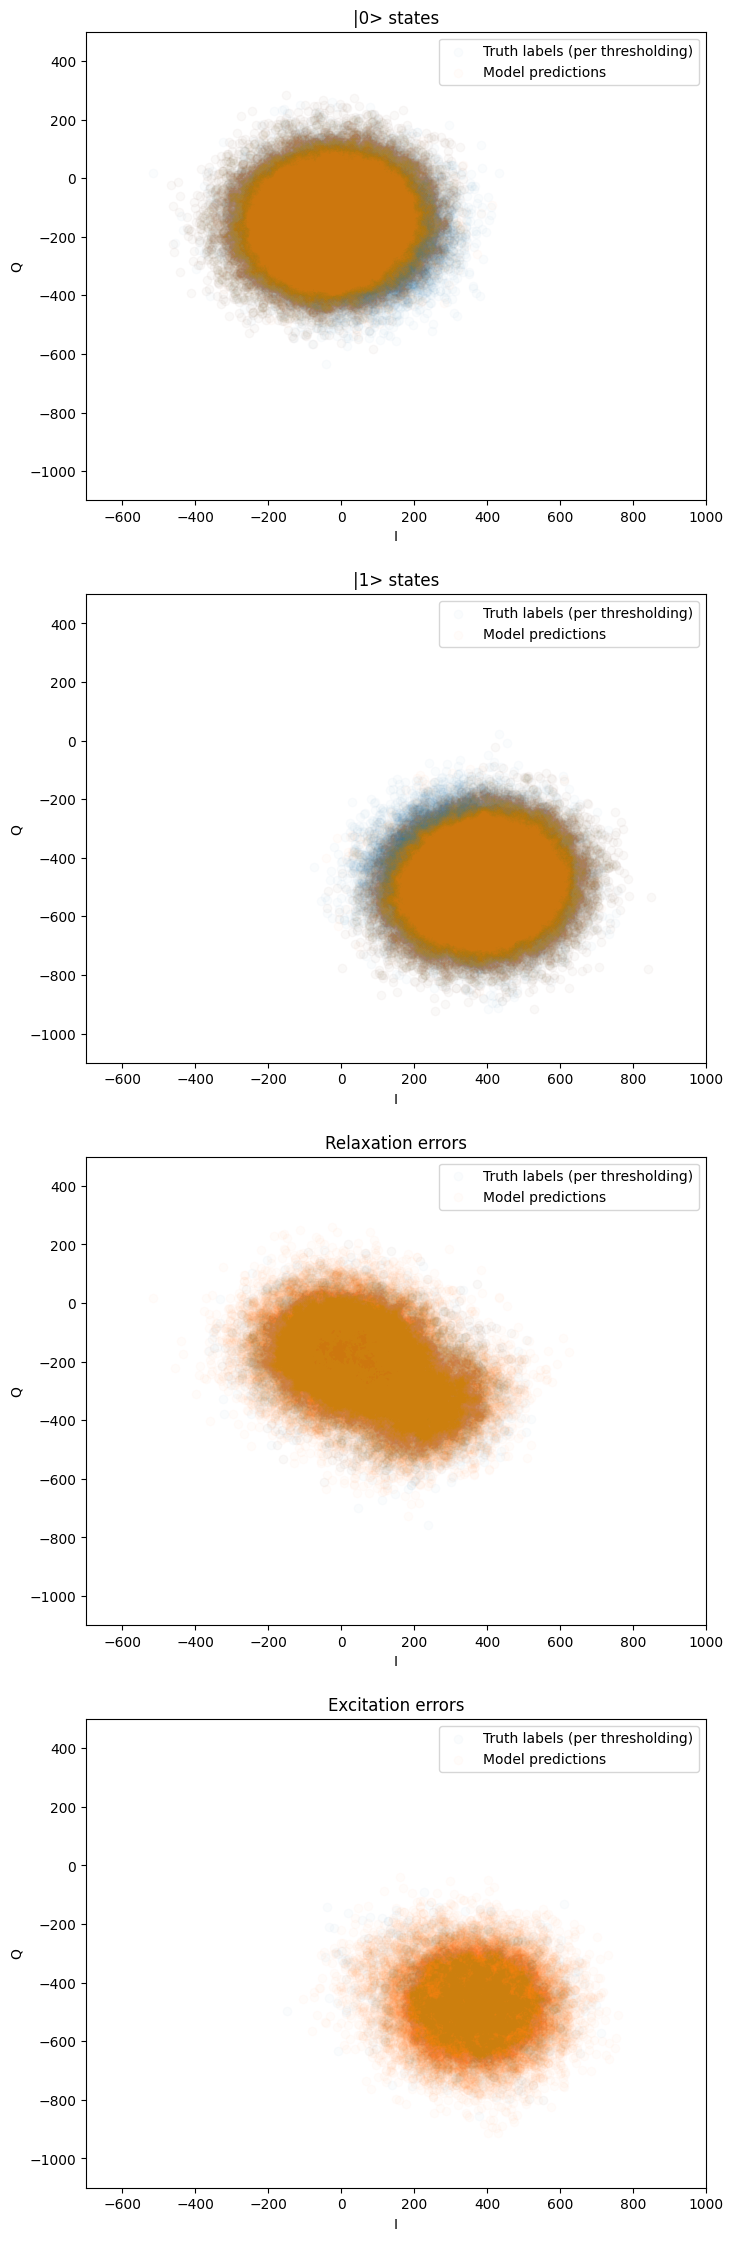

In [2]:
classification_fig_path = os.path.join(LOAD_DIR, "predictions_validation_set.png")
Image(classification_fig_path)

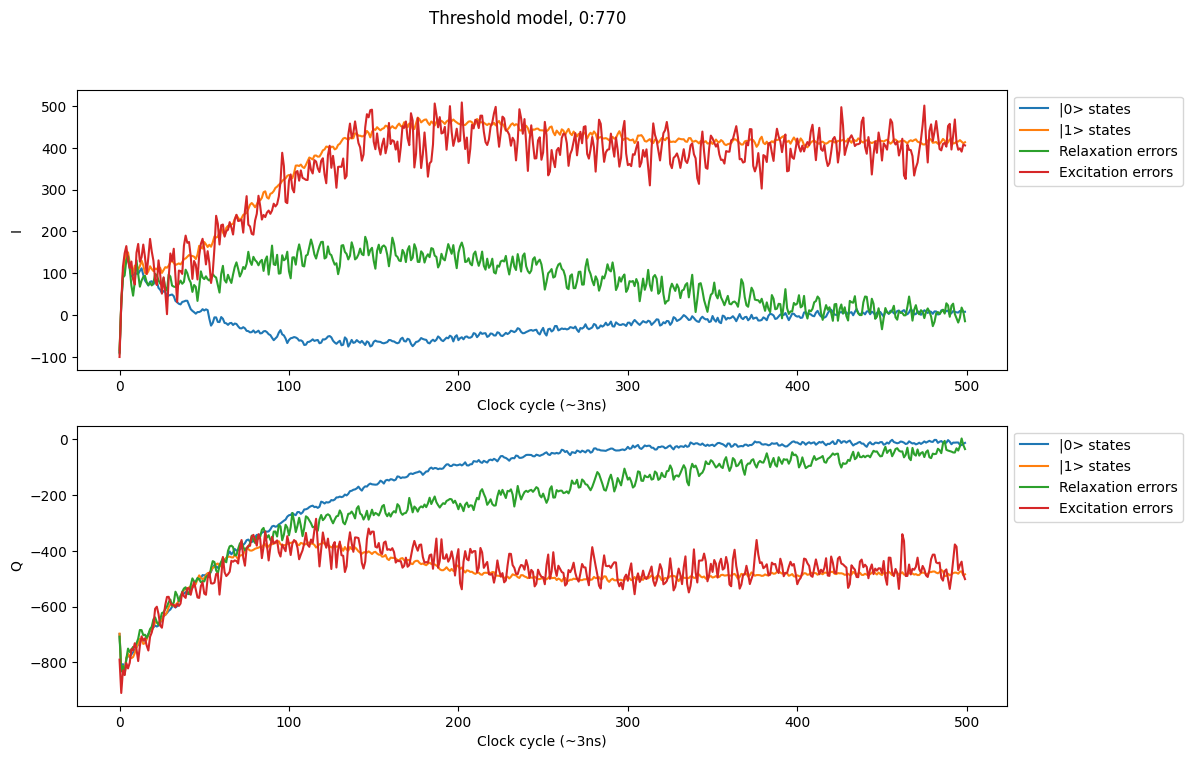

In [3]:
thresh_traces_fig_path = os.path.join(LOAD_DIR, "thresh_traces.png")
Image(thresh_traces_fig_path)

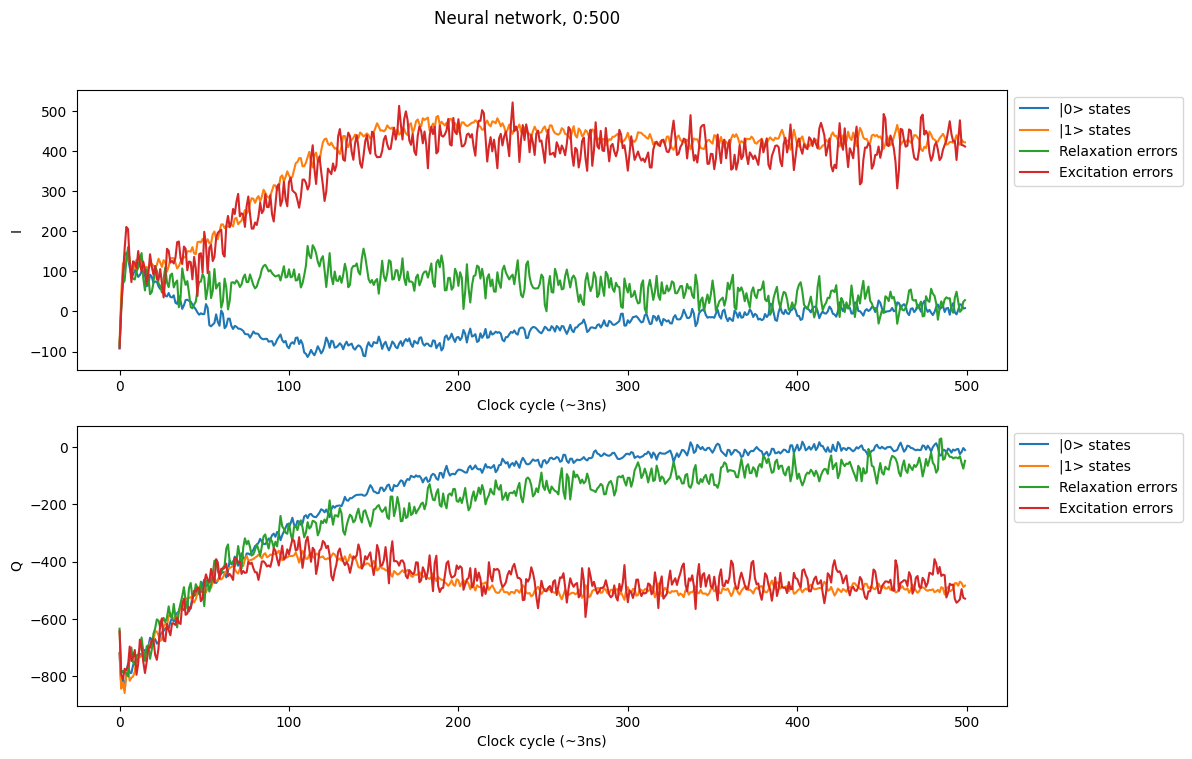

In [4]:
nn_traces_fig_path = os.path.join(LOAD_DIR, "NN_traces.png")
Image(nn_traces_fig_path)

Even with this simplistic labeling schema, there are structural differences between transition and non-transition readouts. But in order to construct a predictive model, it seems like we need more variance in the transition subset to construct a predictive model. This is the first reason we might want to simulate more data.

The second is to lay the groundwork for realistic multi-qubit simulated data. As things stand, we can't collect multi-qubit data using QICK, but we need multi-qubit data to testbench the multi-qubit functionality of QICK. 

# 2. Current state of simulated data

The QuTiP simulation code (again, courtesy of Qihao) uses the Dispersive Hamiltonian model of qubit readout. 

Crucially, $\textbf{the real and simulated data mostly agree on the dispersive phase shift near 1MHz}$.

## 2.a. FFT: Real data

See also $\texttt{transition\_errors\_fft.ipynb}$

In [5]:
import pickle
import copy
import time

import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from radius_labeler import RadiusLabeler # Prefer the other one, but just to have more than one labeling schema
from threshold import ThresholdModel

Load data

In [6]:
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

DATA_OUT_DIR = f'../data/data_0_resplit'# 'qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# load data
X_tv = np.load(os.path.join(DATA_OUT_DIR, 'X_train.npy')).astype(np.float32)
X_test = np.load(os.path.join(DATA_OUT_DIR, 'X_test.npy')).astype(np.float32)  
y_tv = np.load(os.path.join(DATA_OUT_DIR, 'y_train.npy')).astype(np.float32)
y_test = np.load(os.path.join(DATA_OUT_DIR, 'y_test.npy')).astype(np.float32)

# Shuffle train-val
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler]
y_tv = y_tv[tv_shuffler]

# Train-val split
X_train = X_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]
y_train = y_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]

X_val = X_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]
y_val = y_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]

assert(X_val.shape[0]+X_train.shape[0]==X_tv.shape[0])

Label transition errors

Text(0.5, 1.0, 'Transition-labeling method: Discriminating line')

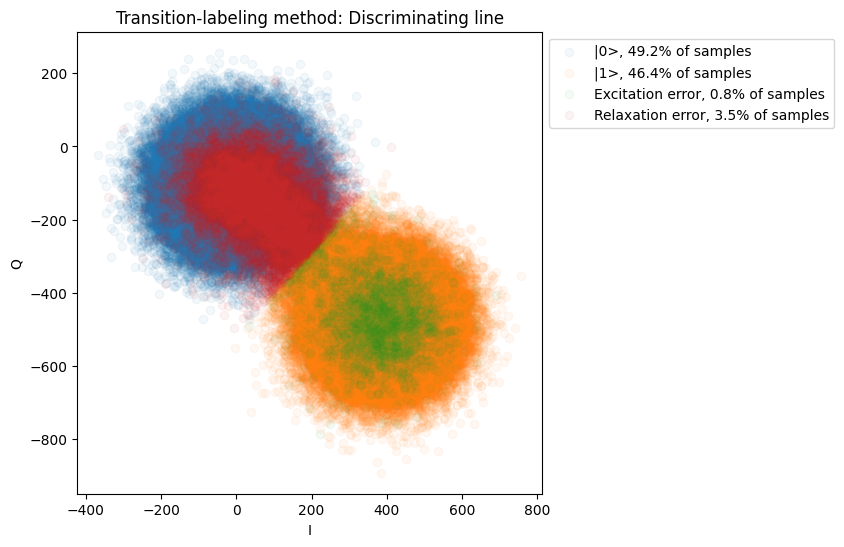

In [7]:
X, y = copy.deepcopy(X_val), copy.deepcopy(y_val)

##################################### Discriminating line labeling #####################################

thresholder = ThresholdModel()
thresholder.fit(X_train, y_train)
THETA_MUL = 0.94
THRESH_MUL = 1.2 #1.25 #1.14
thresholder.theta *= THETA_MUL
thresholder.threshold *= THRESH_MUL

def label_transition_errors(y_true, y_pred):
    assert(y_true.shape==y_pred.shape)
    
    y_new = np.zeros(y_true.shape)
    idx_true_pos = np.where((y_true==1)&(y_pred==1))[0]
    idx_true_neg = np.where((y_true==0)&(y_pred==0))[0]
    idx_excite = np.where((y_true==0)&(y_pred==1))[0]
    idx_relax = np.where((y_true==1)&(y_pred==0))[0]

    #y_new[idx_true_neg] = 0
    y_new[idx_true_pos] = 1
    y_new[idx_excite] = 2 
    y_new[idx_relax] = 3 
    return y_new

y_thresh_pred = thresholder.predict(X)
y_prime = label_transition_errors(y, y_thresh_pred)

X_I_tmean, X_Q_tmean = thresholder.split_and_time_average(X)
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))


idx0 = np.where(y_prime==0)[0]
idx1 = np.where(y_prime==1)[0]
idx2 = np.where(y_prime==2)[0]
idx3 = np.where(y_prime==3)[0]

ax1.scatter(X_I_tmean[idx0], X_Q_tmean[idx0], label = f"|0>, {(100*len(idx0)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx1], X_Q_tmean[idx1], label = f"|1>, {(100*len(idx1)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx2], X_Q_tmean[idx2], label = f"Excitation error, {(100*len(idx2)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.scatter(X_I_tmean[idx3], X_Q_tmean[idx3], label = f"Relaxation error, {(100*len(idx3)/X.shape[0]):.1f}% of samples", alpha=0.05)
ax1.set_xlabel("I")
ax1.set_ylabel("Q")
ax1.legend(bbox_to_anchor = [1,1])
ax1.set_title("Transition-labeling method: Discriminating line")

Fourier transform the data

In [8]:
# Convert to complex
X_I = X[:, [i for i in range(X.shape[1]) if i%2==0]]
X_Q = X[:, [i for i in range(X.shape[1]) if i%2==1]]
X_complex = X_I + 1j*X_Q

# Fourier transform
X_fft = np.fft.fft(X_complex, axis=1)

# Order by increasing frequency 
X_fft_freqs = np.fft.fftfreq(X_complex.shape[1])/(3.25e-9)
freq_ordering = np.argsort(X_fft_freqs)
X_fft_freqs = X_fft_freqs[freq_ordering]
X_fft = X_fft[:, freq_ordering]

Function to find transition frequency (i.e. where the phase-shift happens)

In [9]:
def find_transition_idx(X, diff_window_size = 1, smooth_window_size = 1): 
    # X.shape = (SAMPLE_LENGTH,)
    # Assumes SAMPLE_LENGTH >> window_size
    
    X_window_diff = np.zeros(X.shape)
    for i in range(diff_window_size, X.shape[0]):
        window_diff_i = np.abs(X[i] - X[i - diff_window_size])
        X_window_diff[i] = window_diff_i
        
    X_window_diff = X_window_diff[diff_window_size:]

    # Smooth
    X_window_diff_smoothed = np.zeros(X_window_diff.shape)
    for i in range(smooth_window_size, X_window_diff.shape[0]):
        window_mean_i = np.mean(X_window_diff[i-smooth_window_size:i])
        X_window_diff_smoothed[i] = window_mean_i
        
    X_window_diff_smoothed = X_window_diff_smoothed[smooth_window_size:]

    # Find (approximate) max index
    max_diff_idx = np.where(X_window_diff_smoothed == max(X_window_diff_smoothed))[0]
    return max_diff_idx+diff_window_size+smooth_window_size

Plot amplitude- and frequency-vs-phase, with transition-frequency marked

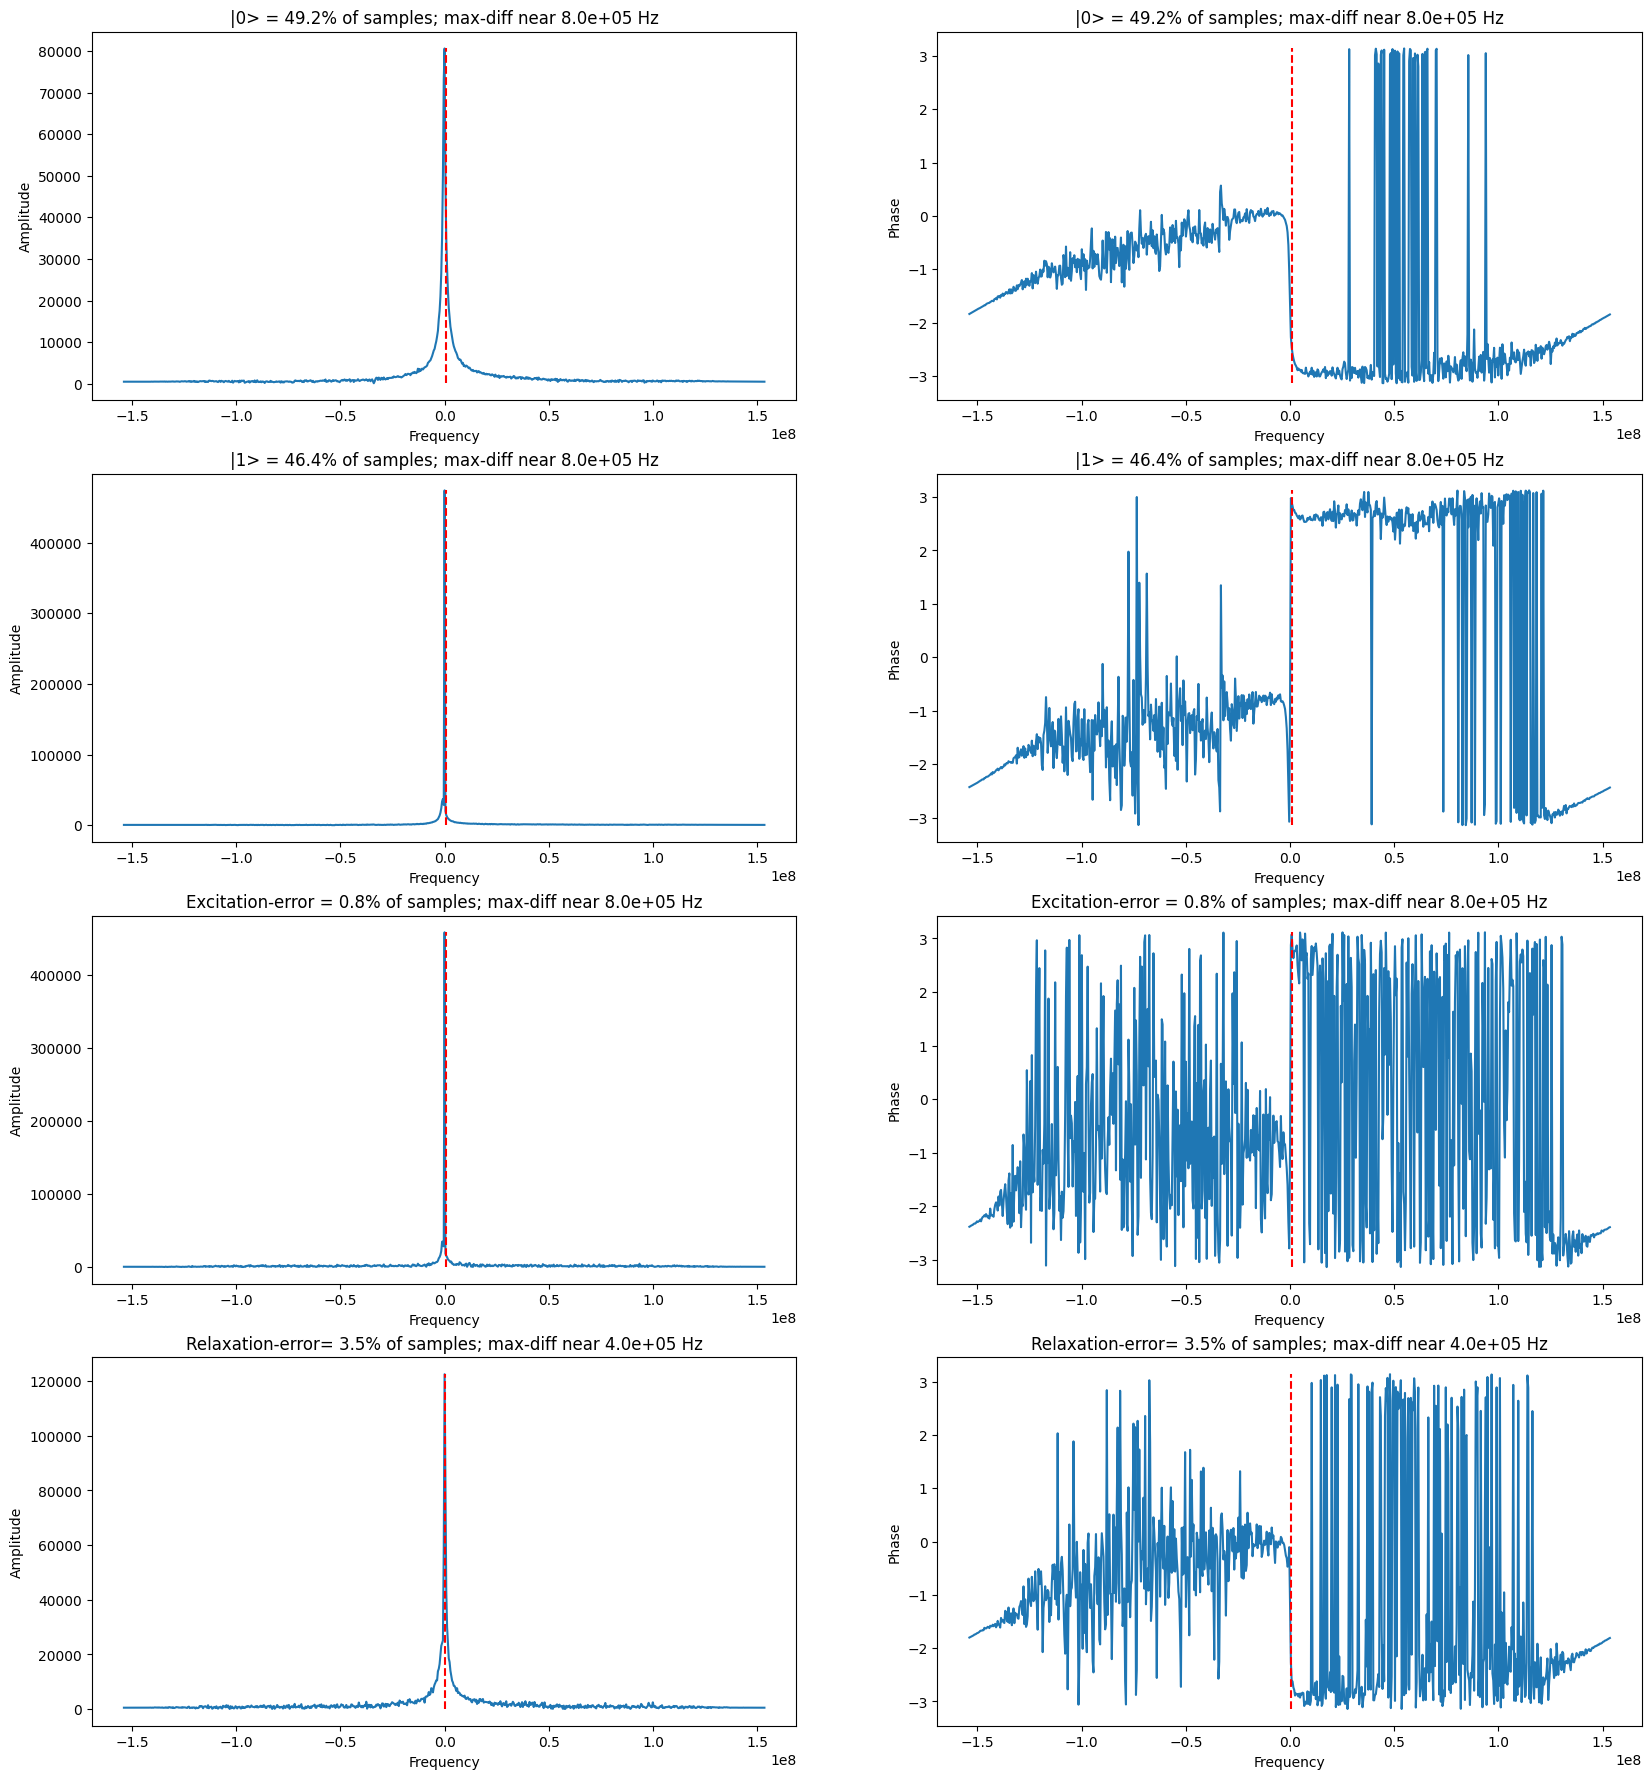

In [10]:
labels = [0, 1, 2, 3]
label_legends = {0: f"|0> = {(100*len(idx0)/X.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx1)/X.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx2)/X.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx3)/X.shape[0]):.1f}% of samples"}

fig, axes = plt.subplots(4, 2, figsize = (20, 22))

for label in labels:
    label_idx = np.where(y_prime==label)[0]
    label_legend = label_legends[label]
    X_fft_label_mean = np.mean(X_fft[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_amp_label_mean_max_diff_idx = find_transition_idx(X_amp_label_mean)
    X_amp_label_mean_max_diff_freq = X_fft_freqs[X_amp_label_mean_max_diff_idx]
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_amp_label_mean), max(X_amp_label_mean), 1000), 'r--')
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")

    X_phase_label_mean = np.angle(X_fft_label_mean)
    X_phase_label_mean_max_diff_idx = find_transition_idx(X_phase_label_mean)
    X_phase_label_mean_max_diff_freq = X_fft_freqs[X_phase_label_mean_max_diff_idx]
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_phase_label_mean), max(X_phase_label_mean), 1000), 'r--')
    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"{label_legends[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")
    


## 2.b. FFT: Simulated data

In [11]:
# QuTiP imports
from qutip import *
from math import pi, fmod
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy.stats import norm
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
from tqdm import tqdm
import json

# Local imports
from sim_data import dispersive_model_MC

Define physical parameters

In [12]:
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

Amp_Slice = 50
Amp_list = 10**np.linspace(-4,-1,Amp_Slice) * 2* pi
index_Amp = 32
Amp = Amp_list[index_Amp]

monte_carlo_config = {"n_shots": int(1e4/2),
                      "dt": 3.25, # ns
                      "T_slice": END_WINDOW,
                      "Amp": Amp,
                      "Omega_C": 6.20 * 2 *pi, # Resonator Freqency
                      "Omega_1": 5.50 * 2 * pi, # Qubit Frequency
                      "eta": 1, # Quantum Efficiency
                      "J_C1": 60 * 2 * pi/1000, # JC Coupling Strength two Qubits
                      "Alpha_1": -247 * 2 * pi/1000, # Anharmonicity of SC Qubits
                      "Gamma_1": 0.05 /1000, # Gamma_1, Decoherence Rate (20.0 us)
                      "Gamma_phi": 0.5 /1000, # Gamma_phi, Dephasing Rate (2.0 us)
                      "Q_C": 40, # Cavity/Resonator Hilbert space truncation
                      "Q_1": 4, # Qubit Hilbert space truncation
                      # Chi = 0.4 * 2 * pi/1000, # Dispersive Shift
}

# monte_carlo_config.update({"Delta": abs(monte_carlo_config['Omega_C'] - monte_carlo_config['Omega_1']), # Detuning
#                "Kappa": 2*monte_carlo_config['Omega_C']/7500 # Resonator Decay Rate ~ 1.65 MHz

# })


Simulate/load data

In [13]:
sim_data_dir = os.path.join("../data/simulated_data", f"0_{monte_carlo_config['T_slice']}_n{monte_carlo_config['n_shots']}")

try:
    I0_all = np.load(os.path.join(sim_data_dir, "I0_all.npy"))
    Q0_all = np.load(os.path.join(sim_data_dir, "Q0_all.npy"))
    I1_all = np.load(os.path.join(sim_data_dir, "I1_all.npy"))
    Q1_all = np.load(os.path.join(sim_data_dir, "Q1_all.npy"))
    with open(os.path.join(sim_data_dir, "mc_config.json"), "r") as f:
        monte_carlo_config = json.load(f)
    
except FileNotFoundError:

    dur_per_1000 = 85
    n_1000 = monte_carlo_config['n_shots']/(1e3)
    exp_dur = dur_per_1000*n_1000
    print(f"Expected duration: {exp_dur//60} minutes, {exp_dur%60} seconds")
    
    out = dispersive_model_MC(monte_carlo_config)
    os.makedirs(sim_data_dir, exist_ok=True)

    I0_all = out["I0_all"]
    np.save(os.path.join(sim_data_dir, "I0_all.npy"), I0_all)
    
    Q0_all = out["Q0_all"]
    np.save(os.path.join(sim_data_dir, "Q0_all.npy"), Q0_all)
    
    I1_all = out["I1_all"]
    np.save(os.path.join(sim_data_dir, "I1_all.npy"), I1_all)
    
    Q1_all = out["Q1_all"]
    np.save(os.path.join(sim_data_dir, "Q1_all.npy"), Q1_all)

    with open(os.path.join(sim_data_dir, "mc_config.json"), "w") as f:
        json.dump(monte_carlo_config, f)

X_0_sim = np.zeros((I0_all.shape[0], 2*I0_all.shape[1]), dtype=I0_all.dtype)
X_0_sim[:, [i for i in range(X_0_sim.shape[1]) if i%2==0]] = I0_all
X_0_sim[:, [i for i in range(X_0_sim.shape[1]) if i%2==1]] = Q0_all
y_0_sim = np.zeros((X_0_sim.shape[0],))

X_1_sim = np.zeros((I1_all.shape[0], 2*I1_all.shape[1]), dtype=I1_all.dtype)
X_1_sim[:, [i for i in range(X_1_sim.shape[1]) if i%2==0]] = I1_all
X_1_sim[:, [i for i in range(X_1_sim.shape[1]) if i%2==1]] = Q1_all
y_1_sim = np.ones((X_1_sim.shape[0],))


#################################################

X_sim = copy.deepcopy(np.concatenate((X_0_sim, X_1_sim), axis=0))
y_sim = copy.deepcopy(np.concatenate((y_0_sim, y_1_sim), axis=0))

Label transition errors

In [14]:
idx_0_sim = np.where(((y_sim==0)&(X_sim[:,-2]<-5)))[0]
idx_1_sim = np.where(((y_sim==1)&(X_sim[:,-2]>4.9)))[0]
idx_excite_sim = np.where(((y_sim==0)&(X_sim[:,-2]>4.9)))[0]  # excitation
idx_relax_sim = np.where(((y_sim==1)&(X_sim[:,-2]<-5)))[0]  # relaxation
idx_other_sim = np.array([i for i in range(y_sim.shape[0]) if i not in np.concatenate((idx_0_sim,idx_1_sim,idx_excite_sim,idx_relax_sim), axis=0)])

print(f"idx_0_sim.shape: {idx_0_sim.shape}")
print(f"idx_1_sim.shape: {idx_1_sim.shape}")
print(f"idx_excite_sim.shape: {idx_excite_sim.shape}")
print(f"idx_relax_sim.shape: {idx_relax_sim.shape}")
print(f"idx_other_sim.shape: {idx_other_sim.shape}")

idx_0_sim.shape: (5000,)
idx_1_sim.shape: (4420,)
idx_excite_sim.shape: (0,)
idx_relax_sim.shape: (542,)
idx_other_sim.shape: (38,)


Fourier transform the data

In [15]:
# Convert to complex
X_I_sim = X_sim[:, [i for i in range(X.shape[1]) if i%2==0]]
X_Q_sim = X_sim[:, [i for i in range(X.shape[1]) if i%2==1]]
X_complex_sim = X_I_sim + 1j*X_Q_sim

# Fourier transform
X_fft_sim = np.fft.fft(X_complex_sim, axis=1)

# Order by increasing frequency 
X_fft_freqs_sim = np.fft.fftfreq(X_complex_sim.shape[1])/(3.25e-9)
freq_ordering_sim = np.argsort(X_fft_freqs_sim)
X_fft_freqs_sim = X_fft_freqs_sim[freq_ordering_sim]
X_fft_sim = X_fft_sim[:, freq_ordering_sim]

Plot amplitude- and frequency-vs-phase, with transition-frequency marked

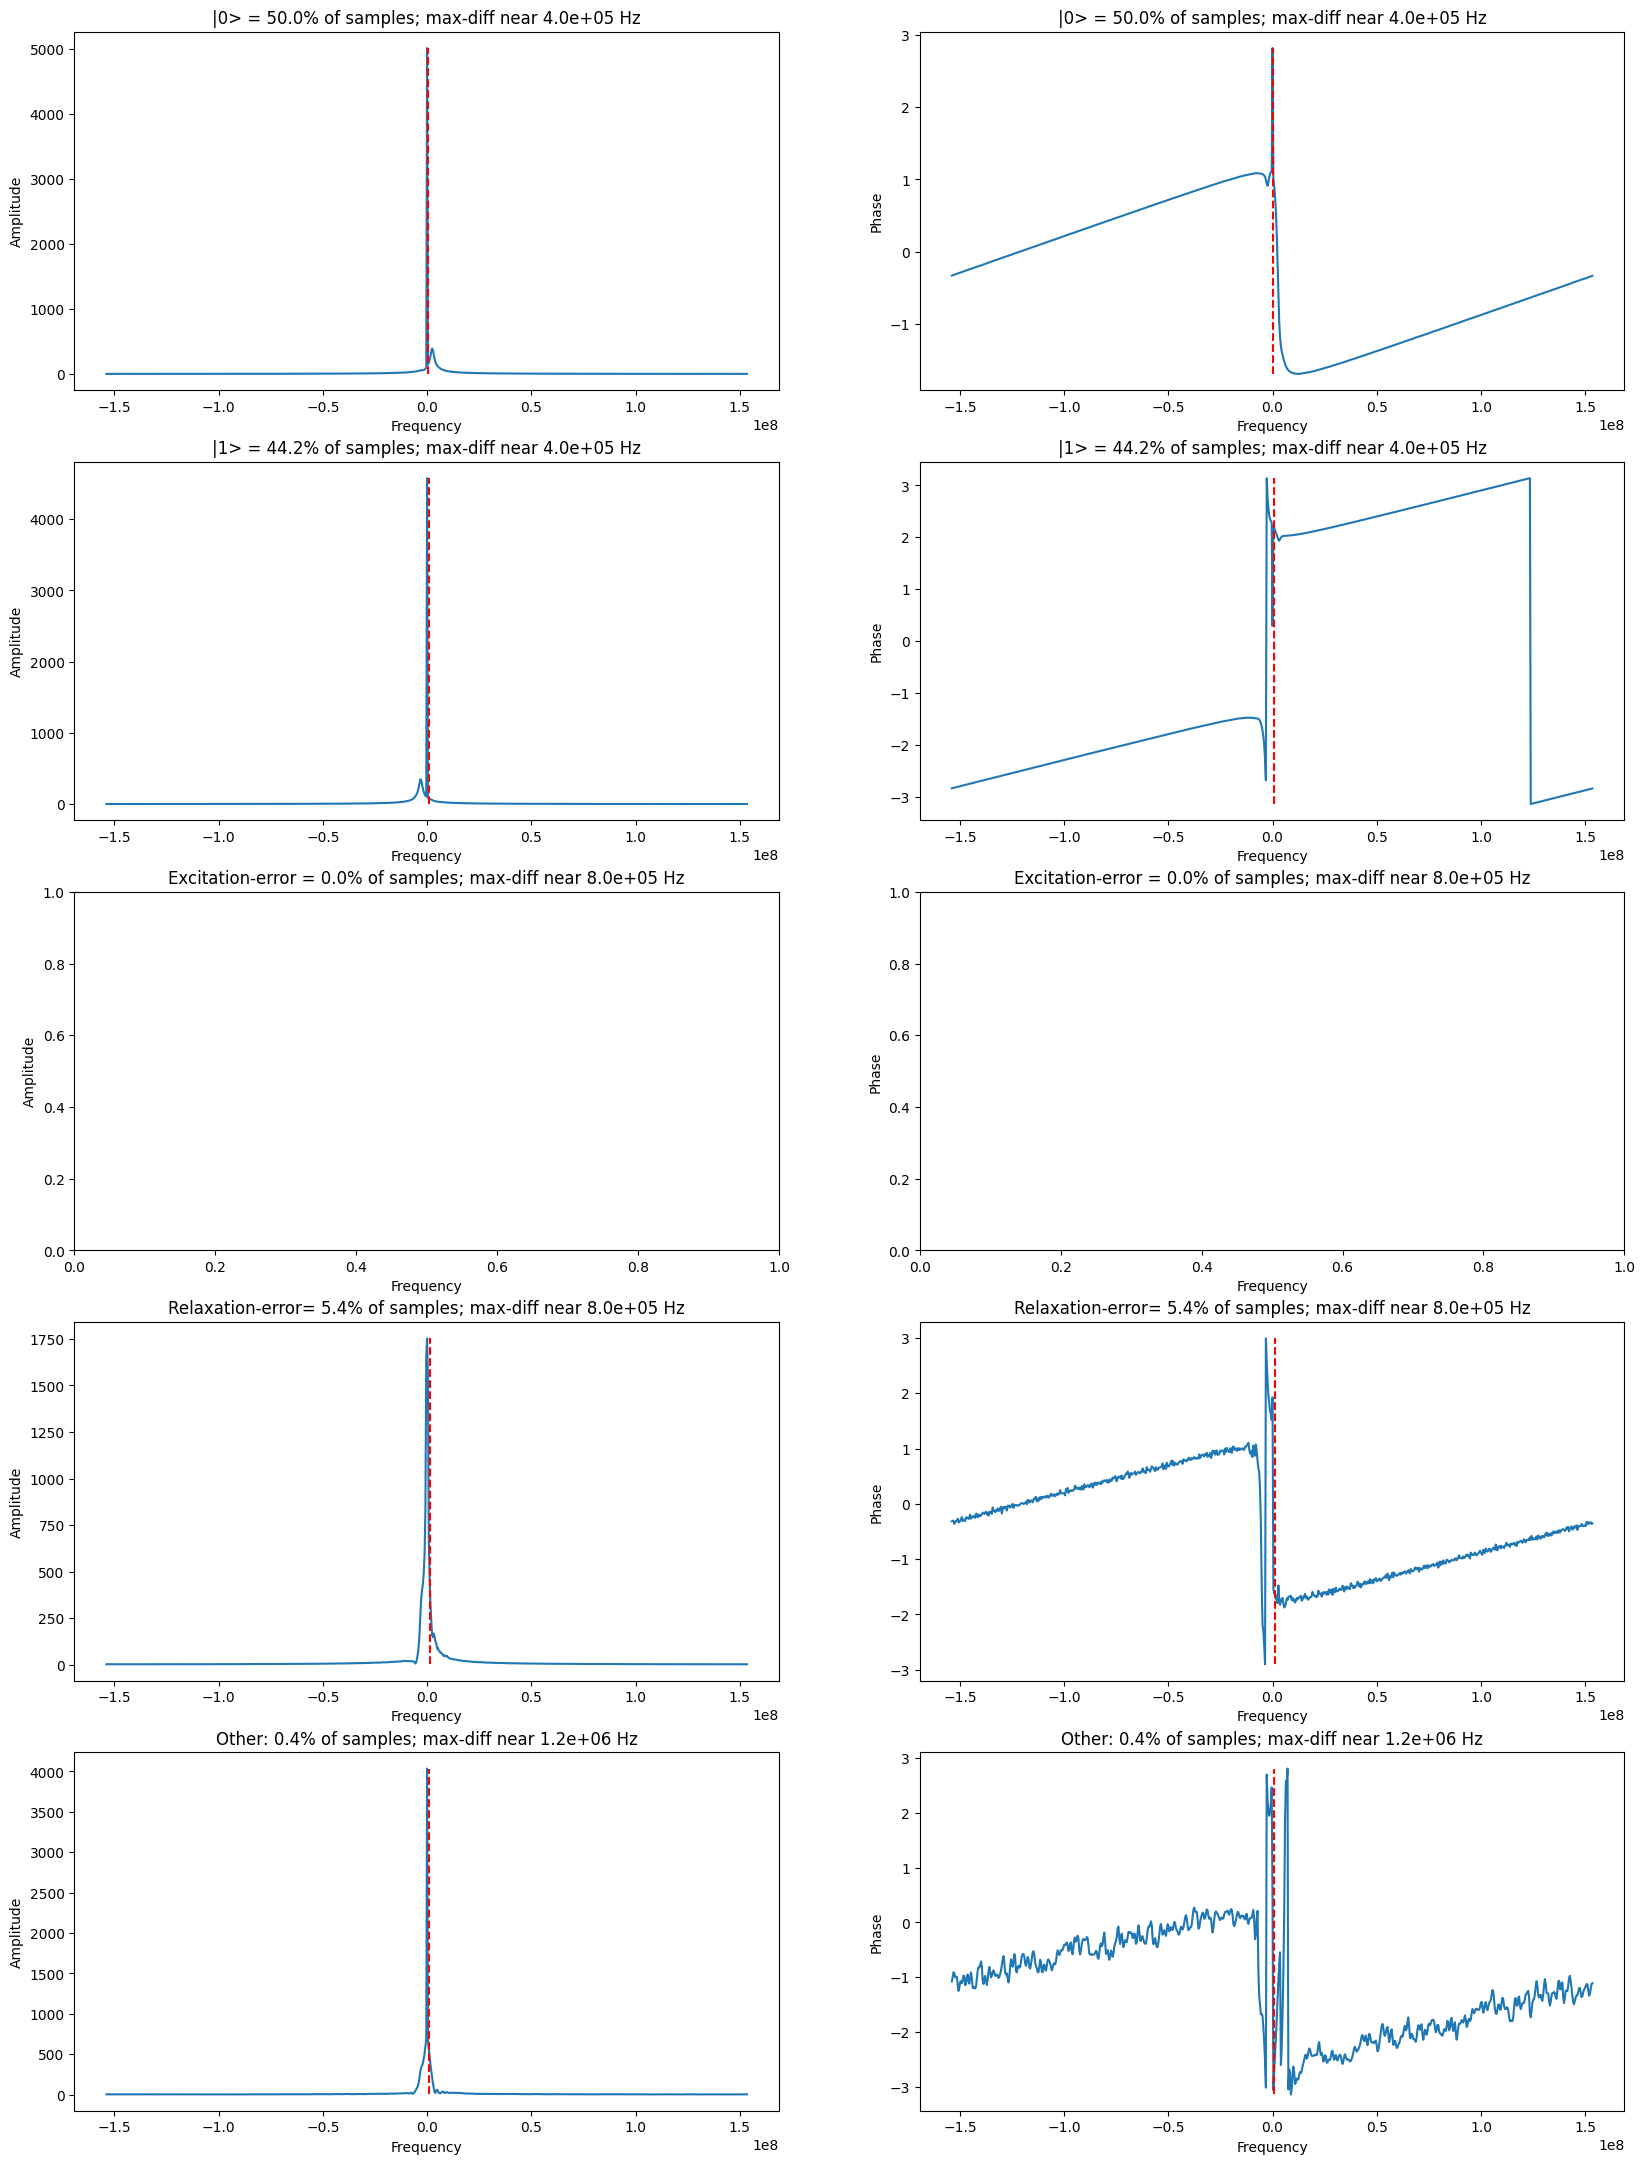

In [16]:
labels_sim = [0, 1, 2, 3, 4]

y_prime_sim = np.zeros(y_sim.shape)
y_prime_sim[idx_1_sim] = 1
y_prime_sim[idx_excite_sim] = 2
y_prime_sim[idx_relax_sim] = 3
y_prime_sim[idx_other_sim] = 4

label_legends_sim = {0: f"|0> = {(100*len(idx_0_sim)/X_sim.shape[0]):.1f}% of samples", 
                 1: f"|1> = {(100*len(idx_1_sim)/X_sim.shape[0]):.1f}% of samples", 
                2: f"Excitation-error = {(100*len(idx_excite_sim)/X_sim.shape[0]):.1f}% of samples",
                3: f"Relaxation-error= {(100*len(idx_relax_sim)/X_sim.shape[0]):.1f}% of samples",
                4: f"Other: {(100*len(idx_other_sim)/X_sim.shape[0]):.1f}% of samples"
                }


fig, axes = plt.subplots(5, 2, figsize = (20, 27))

for label in labels_sim:
    axes[label, 0].set_xlabel("Frequency")
    axes[label, 0].set_ylabel("Amplitude")
    axes[label, 0].set_title(f"{label_legends_sim[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")

    axes[label, 1].set_xlabel("Frequency")
    axes[label, 1].set_ylabel("Phase")
    axes[label, 1].set_title(f"{label_legends_sim[label]}; max-diff near {X_amp_label_mean_max_diff_freq[0]:.1e} Hz")
    
    label_idx = np.where(y_prime_sim==label)[0]
    if len(label_idx)<1:
        continue
    label_legend = label_legends_sim[label]
    X_fft_label_mean = np.mean(X_fft_sim[label_idx], axis=0)
    
    X_amp_label_mean = np.abs(X_fft_label_mean)
    X_amp_label_mean_max_diff_idx = find_transition_idx(X_amp_label_mean)
    X_amp_label_mean_max_diff_freq = X_fft_freqs[X_amp_label_mean_max_diff_idx]
    axes[label, 0].plot(X_fft_freqs, X_amp_label_mean, label = label_legend)
    axes[label, 0].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_amp_label_mean), max(X_amp_label_mean), 1000), 'r--')
    

    X_phase_label_mean = np.angle(X_fft_label_mean)
    X_phase_label_mean_max_diff_idx = find_transition_idx(X_phase_label_mean)
    X_phase_label_mean_max_diff_freq = X_fft_freqs[X_phase_label_mean_max_diff_idx]
    axes[label, 1].plot(X_fft_freqs, X_phase_label_mean, label = label_legend)
    axes[label, 1].plot(X_amp_label_mean_max_diff_freq[0]*np.ones(1000), np.linspace(min(X_phase_label_mean), max(X_phase_label_mean), 1000), 'r--')
    

## 2.c. Sample-averaged trajectories

The sample-averaged IQ trajectories don't match perfectly, but they show some of the same behavior. 

Moreover, the simulated data consists of raw IQ values whereas the real data is coming out of an electronics/amplification pipeline. 

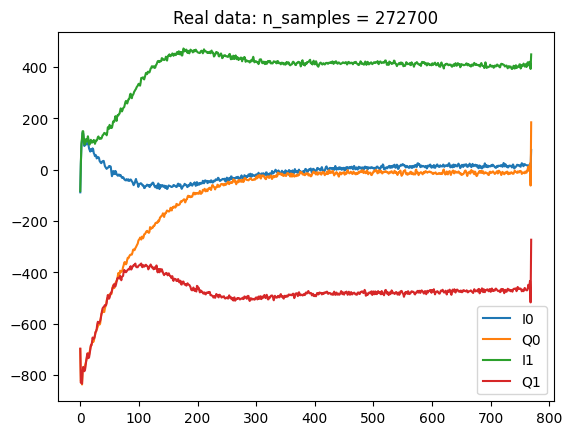

In [17]:
plt.figure()
plt.title(f"Real data: n_samples = {X.shape[0]}")
plt.plot(np.mean(X_I[idx0], axis=0), label="I0")
plt.plot(np.mean(X_Q[idx0], axis=0), label="Q0")
plt.plot(np.mean(X_I[idx1], axis=0), label="I1")
plt.plot(np.mean(X_Q[idx1], axis=0), label="Q1")
plt.legend()

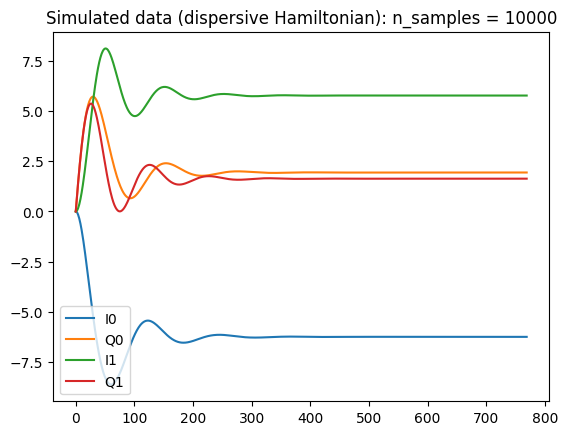

In [18]:
plt.figure()
plt.title(f"Simulated data (dispersive Hamiltonian): n_samples = {X_sim.shape[0]}")
plt.plot(np.mean(X_I_sim[idx_0_sim], axis=0), label="I0")
plt.plot(np.mean(X_Q_sim[idx_0_sim], axis=0), label="Q0")
plt.plot(np.mean(X_I_sim[idx_1_sim], axis=0), label="I1")
plt.plot(np.mean(X_Q_sim[idx_1_sim], axis=0), label="Q1")
plt.legend()

## 2.d. Individual I trajectories: excited-state

This is where the real and simulated data diverge

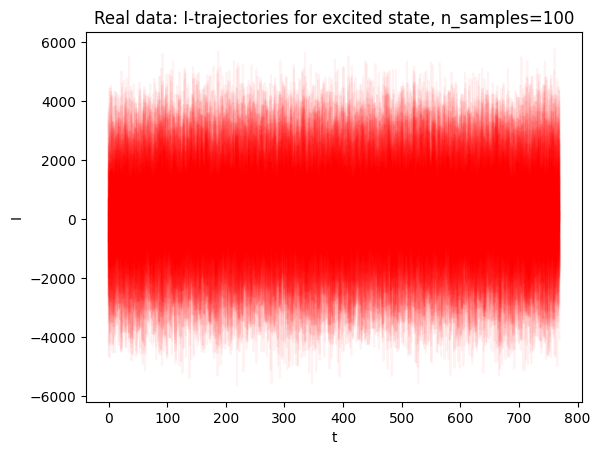

In [19]:
X_I_1 = X_I[np.where(y==1)[0]]
n_samples = 100
indeces = np.random.permutation(range(X_I_1.shape[0]))[:n_samples]

plt.figure()
plt.title(f"Real data: I-trajectories for excited state, n_samples={n_samples}")
plt.xlabel("t")
plt.ylabel("I")
for idx in indeces:
    plt.plot(X_I[idx], c='red', alpha=0.05)
    

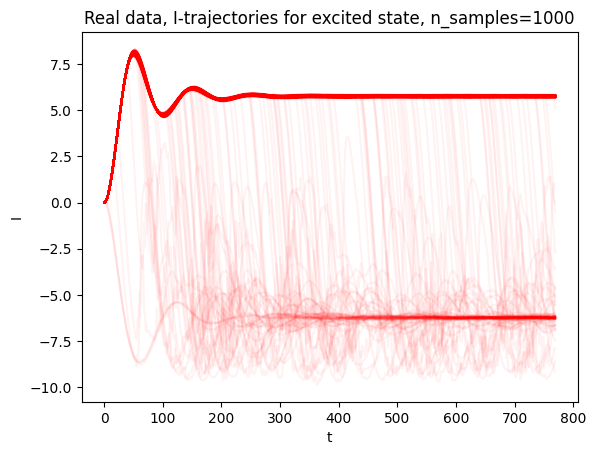

In [21]:
n_samples_sim = 1000
indeces_sim = np.random.permutation(range(I1_all.shape[0]))[:n_samples_sim]

plt.figure()
plt.title(f"Real data, I-trajectories for excited state, n_samples={n_samples_sim}")
plt.xlabel("t")
plt.ylabel("I")
for idx in indeces_sim:
    plt.plot(I1_all[idx], c='red', alpha=0.05)
    

# 3. Takeaways

The simulated data shows the expected dispersive phase shift near 1MHz - the essential physical principle necessary for state discrimination. However, more accurate noise-modeling is necessary in order to justify using simulated data to train ML models. 

According to Qihao, this would mean largely expanding the scope of the simulations, including the simulation of the transmission-lines, amplification and demodulation electronics, etc. I propose to work with Qihao in this direction. 

From there, we could use the simulated data to work on transmission-error-flagging. 

We could also start developing multi-qubit readout simulations, and iterate with Giueppe and Alexis Shuping (Northwestern) on implementing/testbenching QICK's multi-qubit readout functionality. 
